In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
# %matplotlib inline

replicate the paper from yoshua (three inputs one output) 

In [2]:
words = open("makemore/names.txt", "r").read().splitlines()
words[:5], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia'], 32033)

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [102]:
block_size = 3
X, Y = [], []

for w in words[:]:
    # print(w)
    context = [0] * block_size # padding with fixed context length
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [104]:
X.shape, Y.shape, X.dtype, Y.dtype
# X[7], Y

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [13]:
C = torch.randn((27, 2))
# we re using index instead of one-hot for efficiency
C[3] # the embedding vector for 'c'

tensor([-1.0728,  0.5216])

In [8]:
C[torch.tensor([3, 5, 23, 23, 23])]

tensor([[-0.5681,  0.3071],
        [ 0.4508, -1.2219],
        [ 1.1199, -1.8526],
        [ 1.1199, -1.8526],
        [ 1.1199, -1.8526]])

In [19]:
X.shape, C[X].shape # maps every index in X to a vector of size 2, which is the embedding
# (batch_size, seq_length, embedding_dim)

(torch.Size([32, 3]), torch.Size([32, 3, 2]))

In [24]:
C[X][3, 2] # the embedding vector for the third character in the 15th input sequence, which is 'm'

tensor([ 0.5046, -0.5780])

In [26]:
C[13] # the embedding vector for 'm'

tensor([ 0.5046, -0.5780])

In [27]:
C = torch.randn((27, 2))
emb = C[X] # (batch_size, seq_length, embedding_dim)
emb.shape

torch.Size([32, 3, 2])

In [28]:
W1 = torch.randn((3*2, 128))
b1 = torch.randn(128)

In [35]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape # (batch_size, 3*2)

torch.Size([32, 6])

In [40]:
len(torch.unbind(emb, dim=1))
torch.cat(torch.unbind(emb, dim=1), dim=1).shape # inefficient to create new memory

torch.Size([32, 6])

In [43]:
a = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
a.view(3, 2, 2)

tensor([[[ 1,  2],
         [ 3,  4]],

        [[ 5,  6],
         [ 7,  8]],

        [[ 9, 10],
         [11, 12]]])

In [ ]:
a.untyped_storage() # the underlying storage is always a 1D tensor, view() is just a way to interpret it

In [48]:
emb.view(emb.shape[0], -1) == torch.cat(torch.unbind(emb, dim=1), dim=1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [51]:
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # broadcasted addition
# 32, 128
#   , 128
h.shape

torch.Size([32, 128])

In [52]:
W2 = torch.randn((128, 27))
b2 = torch.randn(27)

In [55]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [59]:
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
prob.shape, prob[0].sum()

(torch.Size([32, 27]), tensor(1.))

In [69]:
prob[torch.arange(32), Y] # we want these probs to be bigger, to say 1

tensor([1.8898e-09, 2.9525e-23, 2.6069e-15, 4.8997e-07, 3.1022e-01, 1.7119e-10,
        5.0263e-10, 3.1413e-22, 2.4008e-10, 6.4882e-17, 1.2352e-05, 5.2869e-06,
        4.3881e-05, 5.3994e-15, 3.3887e-05, 2.4391e-05, 1.2150e-15, 1.1686e-04,
        3.7379e-02, 8.3243e-17, 2.6357e-15, 4.6905e-03, 5.7749e-04, 3.7360e-10,
        3.2406e-07, 8.5257e-06, 1.3457e-03, 1.1370e-06, 1.3779e-08, 1.0817e-18,
        3.2458e-03, 1.9880e-04])

In [62]:
loss = -torch.log(prob[torch.arange(32), Y]).mean()
loss

tensor(19.8054)

below is the process

In [118]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [133]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [134]:
sum(p.nelement() for p in parameters) # the whole number of parameters

3481

In [135]:
for p in parameters:
    p.requires_grad = True

In [126]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [70]:
# foward pass
emb = C[X]
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2

counts = logits.exp() # run out of memory when logits is too big
prob = counts / counts.sum(dim=1, keepdim=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [71]:
F.cross_entropy(logits, Y) # below we can see F.cross_entropy is numerically stable and efficient

tensor(17.7697)

In [78]:
logits = torch.tensor([-1, 2, 3, 100]) - 100 # F.cross_entropy will do this for us
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([1.4013e-44, 2.7465e-43, 7.4689e-43, 1.0000e+00])

In [140]:
# lri = []
# lossi = []

for i in range(10000):
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))

    # foward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # lri.append(lr)
    # lossi.append(loss.item())

print(loss.item())

2.3633203506469727


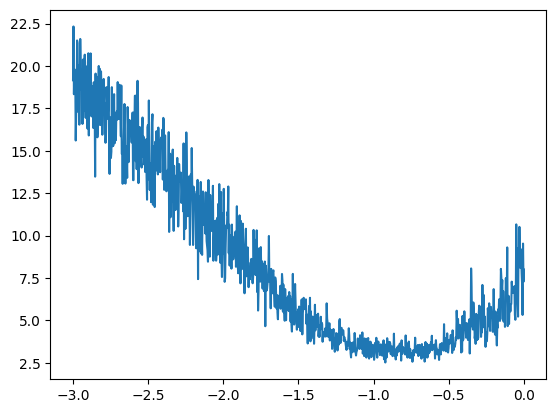

In [131]:
plt.plot(lre, lossi) # here we could see that 10^-1 is a good learning rate

In [113]:
logits.max(dim=1).values, logits.max(dim=1).indices, Y # (32, 27) -> (32)

(tensor([3.3413, 2.5790, 3.3186, 2.1746, 2.9437, 3.3186, 2.5055, 3.6416, 3.4282,
         3.0636, 3.3186, 2.3364, 2.1317, 1.7044, 3.0925, 3.3186, 2.1432, 3.3199,
         3.3186, 3.1228, 3.7072, 3.2652, 3.0925, 3.3186, 3.6478, 1.8399, 3.6445,
         1.9344, 3.3555, 2.4082, 3.3186, 2.4008], grad_fn=<MaxBackward0>),
 tensor([14, 14, 12,  0, 14, 12,  5, 14,  1, 12, 12,  0,  0, 12, 12, 12,  9, 14,
         12, 14, 14,  5, 12, 12, 14,  9, 14, 12, 14,  0, 12,  0]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [141]:
emb = C[X]
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3649, grad_fn=<NllLossBackward0>)

In [ ]:
# training / dev / test split
